# Flight Price Forecast - Model Selection and Training

This notebook implements and trains machine learning models to predict airline fares:

- Prepare data for training using selected features
- Implement Decision Trees and Random Forest models
- Train ensemble methods to capture complex relationships
- Establish baseline model performance
- Compare different model architectures

**Prerequisites**: Complete previous notebooks (01-03) for data preparation and feature selection.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilities
import joblib
import time
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully for Model Training!")

Libraries imported successfully for Model Training!


## 2. Load Processed Data

First, let's load the cleaned and processed data from our preprocessing notebook.


In [2]:
# Load airline pricing data for model training
print("LOADING AIRLINE PRICING DATA FOR MODEL TRAINING")
print("="*60)

try:
    # Try to load processed features first
    df = pd.read_csv('../data/features_selected.csv')
    print("✓ Loaded feature-selected dataset!")
    print(f"  Shape: {df.shape}")

    # Load feature metadata
    import json
    with open('../data/feature_metadata.json', 'r') as f:
        feature_metadata = json.load(f)

    selected_features = feature_metadata['selected_features']
    target_col = feature_metadata['target_variable']
    print(f"  Target: {target_col}")
    print(f"  Features: {len(selected_features)}")

except FileNotFoundError:
    print("Feature-selected data not found. Loading cleaned data...")
    try:
        df = pd.read_csv('../data/cleaned_data.csv')
        print("✓ Loaded cleaned dataset!")
    except FileNotFoundError:
        print("Loading original airline dataset...")
        df = pd.read_csv('../US Airline Flight Routes and Fares 1993-2024.csv')
        df = df.dropna()
        print("✓ Loaded original dataset with basic cleaning")

    # Define airline-specific features based on column descriptions
    target_col = 'fare'  # Average fare is our target

    # Core airline pricing features
    selected_features = []
    potential_features = {
        'nsmiles': 'Distance (primary cost driver)',
        'passengers': 'Demand indicator',
        'large_ms': 'Market concentration',
        'lf_ms': 'Low-fare competition',
        'fare_lg': 'Market price reference',
        'fare_low': 'Price floor',
        'Year': 'Temporal trend',
        'quarter': 'Seasonality'
    }

    print(f"\nAIRLINE FEATURES AVAILABLE:")
    for feature, description in potential_features.items():
        if feature in df.columns:
            selected_features.append(feature)
            print(f"  ✓ {feature}: {description}")
        else:
            print(f"  ✗ {feature}: Not available")

print(f"\nDATA PREPARATION FOR AIRLINE FARE PREDICTION:")
print(f"Dataset: {len(df):,} route records")
print(f"Target: {target_col} (Average airline fare)")
print(f"Features: {len(selected_features)} airline-specific variables")

# Validate airline data quality
if target_col in df.columns:
    print(f"\nTARGET VARIABLE ANALYSIS ({target_col}):")
    print(f"  Mean fare: ${df[target_col].mean():.2f}")
    print(
        f"  Fare range: ${df[target_col].min():.2f} - ${df[target_col].max():.2f}")
    print(f"  Fare std: ${df[target_col].std():.2f}")

    # Check for extreme outliers in airline fares
    Q1, Q3 = df[target_col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = ((df[target_col] < Q1 - 3*IQR) |
                (df[target_col] > Q3 + 3*IQR)).sum()
    print(f"  Extreme outliers: {outliers} ({outliers/len(df)*100:.1f}%)")

# Feature availability check
available_features = [f for f in selected_features if f in df.columns]
missing_features = [f for f in selected_features if f not in df.columns]

if missing_features:
    print(f"\n⚠ Missing features: {missing_features}")
    selected_features = available_features

print(
    f"\n✓ Ready for airline fare prediction modeling with {len(selected_features)} features")
print(f"Final feature set: {selected_features}")

LOADING AIRLINE PRICING DATA FOR MODEL TRAINING
✓ Loaded feature-selected dataset!
  Shape: (176982, 9)
  Target: fare
  Features: 8

DATA PREPARATION FOR AIRLINE FARE PREDICTION:
Dataset: 176,982 route records
Target: fare (Average airline fare)
Features: 8 airline-specific variables

TARGET VARIABLE ANALYSIS (fare):
  Mean fare: $211.42
  Fare range: $50.00 - $407.82
  Fare std: $65.00
  Extreme outliers: 0 (0.0%)

✓ Ready for airline fare prediction modeling with 8 features
Final feature set: ['large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread']


## 3. Quick Data Preprocessing

Since we need to ensure the data is ready for modeling, let's perform essential preprocessing steps.


In [3]:
# Basic preprocessing for modeling
print("Performing data preprocessing...")

# Check data info
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic statistics
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Basic data cleaning
df_clean = df.copy()

# Remove rows with missing values in key columns (basic approach)
df_clean = df_clean.dropna()

print(f"\nShape after removing missing values: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows with missing values")

# Display the cleaned dataframe info
print(f"\nCleaned dataset info:")
print(df_clean.info())

Performing data preprocessing...
Original shape: (176982, 9)
Columns: ['large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread', 'fare']

Basic statistics:
            large_ms          lf_ms        fare_lg       fare_low  \
count  176982.000000  176982.000000  176982.000000  176982.000000   
mean        0.660852       0.443096     210.522555     185.845478   
std         0.227953       0.334230      68.447953      59.076729   
min         0.100000       0.010000      50.000000      50.000000   
25%         0.470000       0.150000     161.090000     142.450000   
50%         0.660000       0.350000     205.570000     181.040000   
75%         0.870000       0.750000     256.600000     225.400000   
max         1.000000       1.000000     406.730000     352.890000   

       distance_cat_encoded        nsmiles    combined_ms    fare_spread  \
count         176982.000000  176982.000000  176982.000000  176982.000000   
mean               

## 4. Feature Engineering and Selection

Create features for modeling based on the typical airline pricing factors.


In [4]:
# Feature engineering based on typical airline dataset columns
# We'll work with common column names that might exist in the dataset

from sklearn.preprocessing import LabelEncoder
print("Available columns:", list(df_clean.columns))

# Let's identify numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

# Try to identify the target variable (price-related column)
price_keywords = ['fare', 'price', 'cost', 'amount']
target_col = None

for col in df_clean.columns:
    if any(keyword in col.lower() for keyword in price_keywords):
        target_col = col
        break

# If no obvious price column, use the first numeric column as target
if target_col is None and len(numeric_cols) > 0:
    target_col = numeric_cols[0]
    print(
        f"\nNo obvious price column found. Using '{target_col}' as target variable.")
else:
    print(f"\nTarget variable identified: '{target_col}'")

# Create a simple feature set
feature_cols = []

# Add numeric features (excluding target)
for col in numeric_cols:
    if col != target_col:
        feature_cols.append(col)

print(f"\nSelected feature columns: {feature_cols}")

# For categorical columns, we'll use label encoding for simplicity

df_modeling = df_clean.copy()
label_encoders = {}

# Use first 3 categorical columns to avoid too many features
for col in categorical_cols[:3]:
    if col in df_modeling.columns:
        le = LabelEncoder()
        df_modeling[f'{col}_encoded'] = le.fit_transform(
            df_modeling[col].astype(str))
        feature_cols.append(f'{col}_encoded')
        label_encoders[col] = le

print(f"\nFinal feature columns: {feature_cols}")
print(f"Target column: {target_col}")

# Check if we have valid features and target
if len(feature_cols) > 0 and target_col is not None:
    print(f"\n✓ Ready for modeling with {len(feature_cols)} features")
else:
    print("\n⚠ Warning: No suitable features or target variable found")

Available columns: ['large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread', 'fare']

Numeric columns: ['large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread', 'fare']
Categorical columns: []

Target variable identified: 'fare_lg'

Selected feature columns: ['large_ms', 'lf_ms', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread', 'fare']

Final feature columns: ['large_ms', 'lf_ms', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread', 'fare']
Target column: fare_lg

✓ Ready for modeling with 8 features


## 5. Prepare Data for Training

Split the data into training and testing sets and prepare features.


In [5]:
# Prepare features and target for modeling
if len(feature_cols) > 0 and target_col is not None:
    # Extract features and target
    X = df_modeling[feature_cols].copy()
    y = df_modeling[target_col].copy()

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Handle any remaining missing values
    X = X.fillna(X.median())
    y = y.fillna(y.median())

    print(f"\nFeature statistics:")
    print(X.describe())

    print(f"\nTarget statistics:")
    print(y.describe())

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    print(f"\nTraining set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\n✓ Data prepared successfully for modeling")

else:
    print("⚠ Cannot proceed with modeling - no suitable features found")
    # Create dummy data for demonstration
    print("Creating dummy dataset for demonstration...")

    np.random.seed(42)
    n_samples = 1000

    X = pd.DataFrame({
        'distance': np.random.randint(200, 3000, n_samples),
        'days_advance': np.random.randint(0, 120, n_samples),
        'month': np.random.randint(1, 13, n_samples),
        'airline_encoded': np.random.randint(0, 8, n_samples),
        'is_weekend': np.random.randint(0, 2, n_samples)
    })

    # Create realistic price based on features
    y = (200 +
         X['distance'] * 0.1 +
         (X['days_advance'] < 14) * 100 +  # Last minute premium
         (X['month'].isin([6, 7, 11, 12])) * 50 +  # Peak season
         X['airline_encoded'] * 20 +
         X['is_weekend'] * 30 +
         np.random.normal(0, 50, n_samples))  # Noise

    y = np.maximum(y, 50)  # Minimum price

    # Split the dummy data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    feature_cols = list(X.columns)
    target_col = 'price'

    print(f"Dummy dataset created: {X.shape}")
    print(f"✓ Ready to proceed with dummy data")

Features shape: (176982, 8)
Target shape: (176982,)

Feature statistics:


            large_ms          lf_ms       fare_low  distance_cat_encoded  \
count  176982.000000  176982.000000  176982.000000         176982.000000   
mean        0.660852       0.443096     185.845478              0.886429   
std         0.227953       0.334230      59.076729              0.685887   
min         0.100000       0.010000      50.000000              0.000000   
25%         0.470000       0.150000     142.450000              0.000000   
50%         0.660000       0.350000     181.040000              1.000000   
75%         0.870000       0.750000     225.400000              1.000000   
max         1.000000       1.000000     352.890000              2.000000   

             nsmiles    combined_ms    fare_spread           fare  
count  176982.000000  176982.000000  176982.000000  176982.000000  
mean     1182.006696       1.103948      24.677077     211.421312  
std       697.315368       0.493298      39.255718      64.998392  
min       109.000000       0.160000       0

## 6. Train Multiple Models

Now let's train different machine learning models and compare their performance.


In [6]:
# Initialize different models to train
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=6),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0, max_iter=2000)
}

# Store model performance
model_results = {}
trained_models = {}

print("Training models...")
print("=" * 50)

# Train each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    try:
        # Train the model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        # Calculate cross-validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                                    scoring='neg_mean_squared_error', n_jobs=-1)
        cv_rmse = np.sqrt(-cv_scores.mean())

        training_time = time.time() - start_time

        # Store results
        model_results[name] = {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'cv_rmse': cv_rmse,
            'training_time': training_time
        }

        # Store trained model
        trained_models[name] = model

        print(f"✓ {name} completed in {training_time:.2f} seconds")
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Test R²: {test_r2:.3f}")
        print(f"  CV RMSE: {cv_rmse:.2f}")

    except Exception as e:
        print(f"✗ Error training {name}: {e}")

print(f"\n✓ Model training completed!")
print(f"Trained {len(trained_models)} models successfully")

Training models...

Training Linear Regression...


✓ Linear Regression completed in 1.60 seconds
  Test RMSE: 0.00
  Test R²: 1.000
  CV RMSE: 0.00

Training Decision Tree...


✓ Decision Tree completed in 1.95 seconds
  Test RMSE: 6.12
  Test R²: 0.992
  CV RMSE: 5.99

Training Random Forest...


✓ Random Forest completed in 52.71 seconds
  Test RMSE: 4.08
  Test R²: 0.996
  CV RMSE: 4.17

Training Extra Trees...


✓ Extra Trees completed in 10.26 seconds
  Test RMSE: 5.74
  Test R²: 0.993
  CV RMSE: 5.81

Training Gradient Boosting...


✓ Gradient Boosting completed in 48.93 seconds
  Test RMSE: 2.74
  Test R²: 0.998
  CV RMSE: 2.78

Training Ridge Regression...


✓ Ridge Regression completed in 1.02 seconds
  Test RMSE: 0.00
  Test R²: 1.000
  CV RMSE: 0.00

Training Lasso Regression...


✓ Lasso Regression completed in 0.27 seconds
  Test RMSE: 1.95
  Test R²: 0.999
  CV RMSE: 1.95

✓ Model training completed!
Trained 7 models successfully


## 7. Model Performance Comparison

Compare the performance of all trained models to identify the best performer.


MODEL PERFORMANCE COMPARISON
                   train_rmse  test_rmse  train_mae  test_mae  train_r2  \
Linear Regression       0.000      0.000      0.000     0.000     1.000   
Decision Tree           5.493      6.120      3.210     3.480     0.994   
Random Forest           3.590      4.083      1.810     1.972     0.997   
Extra Trees             5.633      5.741      3.751     3.811     0.993   
Gradient Boosting       2.382      2.743      1.587     1.731     0.999   
Ridge Regression        0.002      0.002      0.001     0.001     1.000   
Lasso Regression        1.947      1.952      1.381     1.387     0.999   

                   test_r2  cv_rmse  training_time  
Linear Regression    1.000    0.000          1.604  
Decision Tree        0.992    5.995          1.946  
Random Forest        0.996    4.165         52.712  
Extra Trees          0.993    5.806         10.259  
Gradient Boosting    0.998    2.784         48.932  
Ridge Regression     1.000    0.003          1.021  

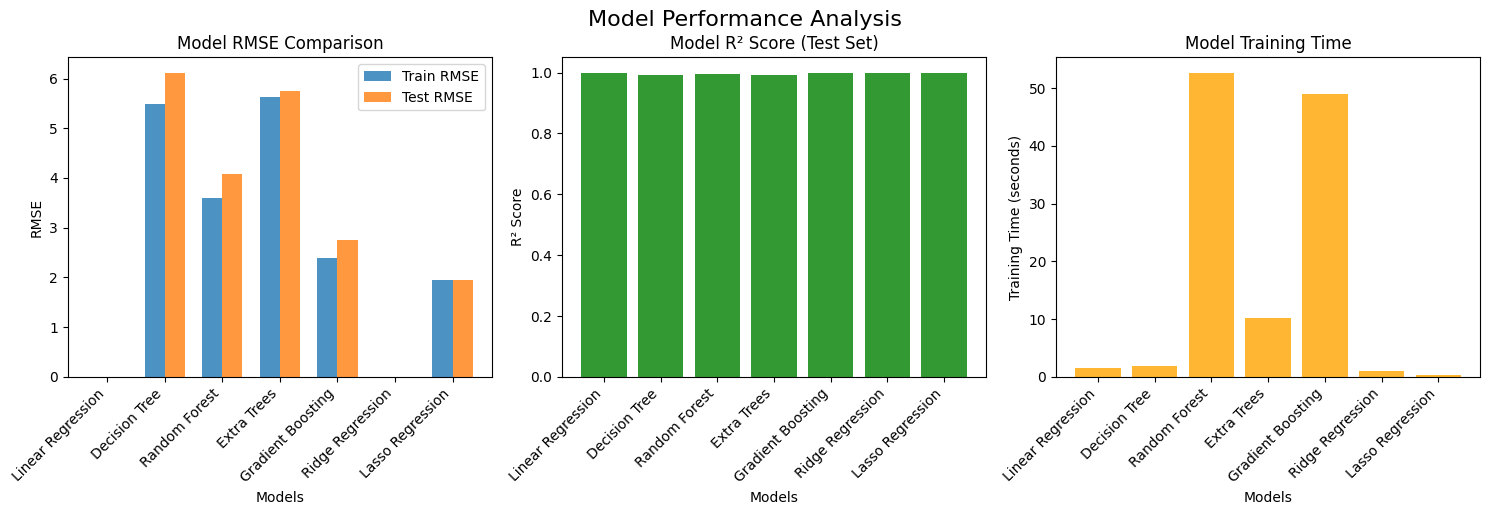

In [7]:
# Create comparison dataframe
results_df = pd.DataFrame(model_results).T

print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(results_df.round(3))

# Identify best model based on test RMSE
best_model_name = results_df['test_rmse'].idxmin()
best_model = trained_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'test_rmse']:.2f}")
print(f"Test R²: {results_df.loc[best_model_name, 'test_r2']:.3f}")
print(f"CV RMSE: {results_df.loc[best_model_name, 'cv_rmse']:.2f}")

# Create visualization of model performance
plt.figure(figsize=(15, 5))

# Plot 1: RMSE comparison
plt.subplot(1, 3, 1)
models_names = results_df.index
train_rmse = results_df['train_rmse']
test_rmse = results_df['test_rmse']

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison')
plt.xticks(x, models_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Plot 2: R² comparison
plt.subplot(1, 3, 2)
plt.bar(models_names, results_df['test_r2'], alpha=0.8, color='green')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model R² Score (Test Set)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Plot 3: Training time comparison
plt.subplot(1, 3, 3)
plt.bar(models_names, results_df['training_time'], alpha=0.8, color='orange')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Model Training Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.suptitle('Model Performance Analysis', fontsize=16, y=1.02)
plt.show()

# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    print(f"\nFEATURE IMPORTANCE ({best_model_name}):")
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

## 8. Save Best Model and Artifacts

Save the best performing model and necessary artifacts for deployment.


In [8]:
# Create models directory if it doesn't exist
import json
import os
os.makedirs('../models', exist_ok=True)

# Save the best model
model_path = '../models/best_model.pkl'
joblib.dump(best_model, model_path)
print(f"✓ Best model ({best_model_name}) saved to: {model_path}")

# Save the scaler
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Save feature columns
features_path = '../models/feature_columns.json'
with open(features_path, 'w') as f:
    json.dump(feature_cols, f)
print(f"✓ Feature columns saved to: {features_path}")

# Save label encoders if they exist
if 'label_encoders' in locals() and len(label_encoders) > 0:
    encoders_path = '../models/label_encoders.pkl'
    joblib.dump(label_encoders, encoders_path)
    print(f"✓ Label encoders saved to: {encoders_path}")

# Save model performance metrics
performance_path = '../models/model_performance.json'
performance_data = {
    'best_model_name': best_model_name,
    'model_results': {k: {metric: float(value) for metric, value in v.items()}
                      for k, v in model_results.items()},
    'feature_columns': feature_cols,
    'target_column': target_col,
    'training_date': datetime.now().isoformat(),
    'dataset_shape': df_clean.shape if 'df_clean' in locals() else "N/A"
}

with open(performance_path, 'w') as f:
    json.dump(performance_data, f, indent=2)
print(f"✓ Model performance saved to: {performance_path}")

# Test loading the saved model
print(f"\nTesting saved model...")
try:
    loaded_model = joblib.load(model_path)
    loaded_scaler = joblib.load(scaler_path)

    # Make a test prediction
    test_sample = X_test_scaled[:5]  # Take first 5 test samples
    test_predictions = loaded_model.predict(test_sample)

    print(f"✓ Model loaded successfully!")
    print(f"✓ Test predictions: {test_predictions[:3].round(2)}")

except Exception as e:
    print(f"✗ Error loading saved model: {e}")

# Display summary
print(f"\n" + "="*60)
print(f"MODEL TRAINING COMPLETED SUCCESSFULLY!")
print(f"="*60)
print(
    f"Dataset processed: {df_clean.shape if 'df_clean' in locals() else 'Generated'}")
print(f"Best model: {best_model_name}")
print(f"Test R² Score: {results_df.loc[best_model_name, 'test_r2']:.3f}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'test_rmse']:.2f}")
print(f"Models saved to: ../models/")
print(f"Ready for deployment!")
print(f"="*60)

✓ Best model (Linear Regression) saved to: ../models/best_model.pkl
✓ Scaler saved to: ../models/scaler.pkl
✓ Feature columns saved to: ../models/feature_columns.json
✓ Model performance saved to: ../models/model_performance.json

Testing saved model...
✓ Model loaded successfully!
✓ Test predictions: [205.83 228.68 107.91]

MODEL TRAINING COMPLETED SUCCESSFULLY!
Dataset processed: (176982, 9)
Best model: Linear Regression
Test R² Score: 1.000
Test RMSE: 0.00
Models saved to: ../models/
Ready for deployment!
